In [1]:
import libs
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from netCDF4 import Dataset
import time
import re

In [2]:
file_path = r"G:\0_postgraduate\DMSP\data\2011\15s1\dms_20110101_15s1.001.nc"
file = libs.File(file_path)
data = file.original_data

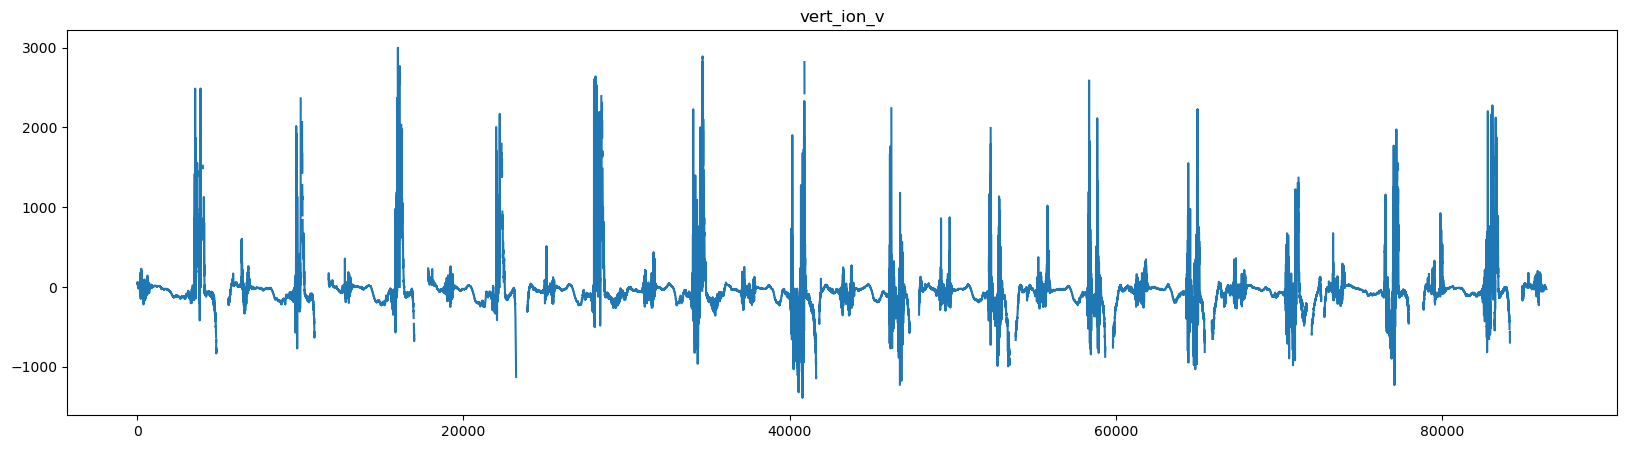

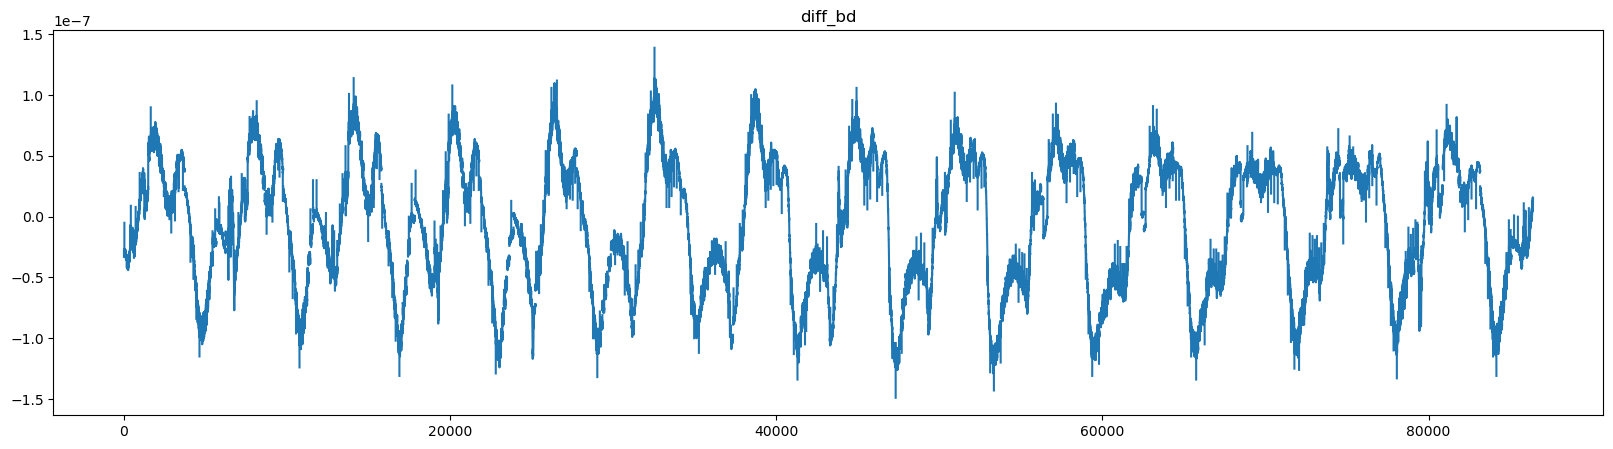

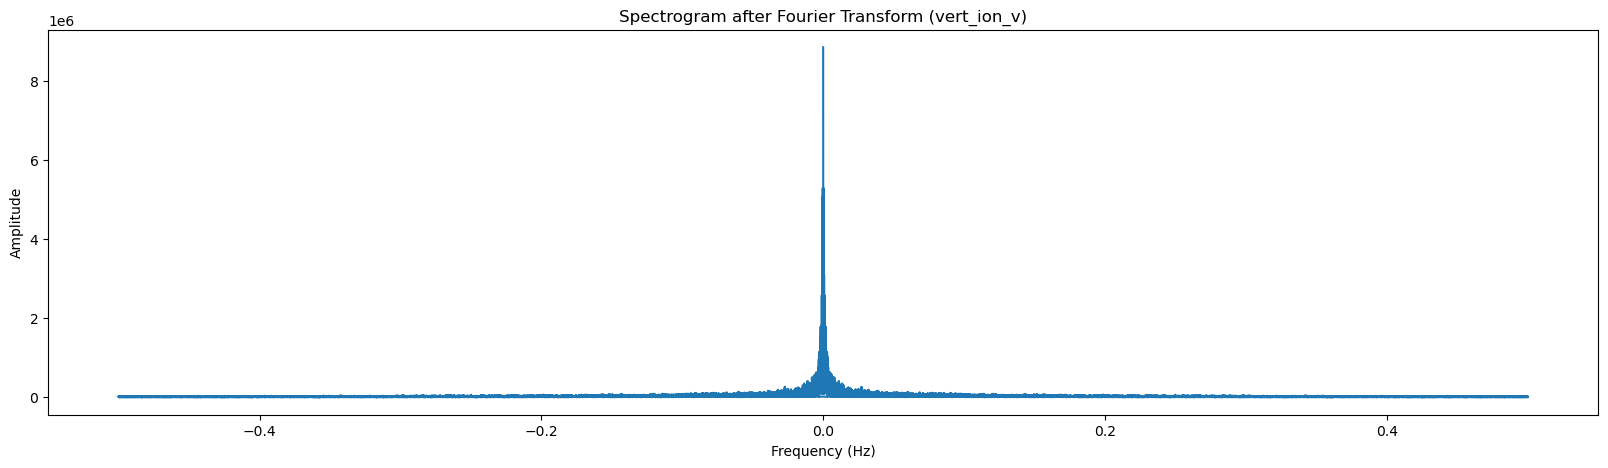

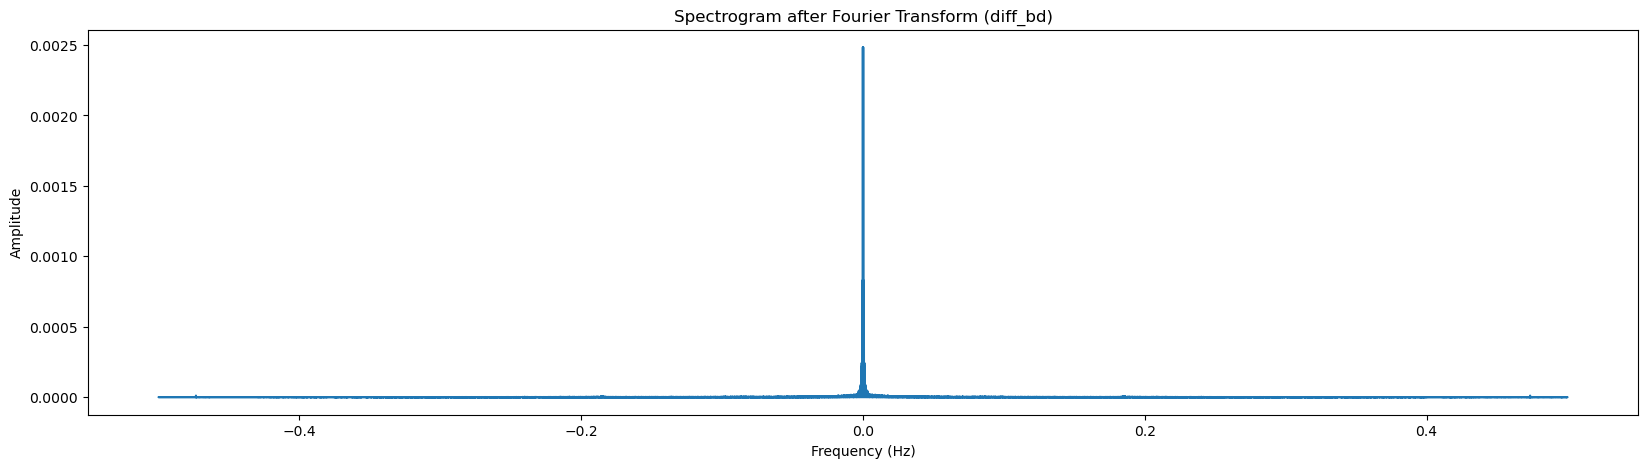

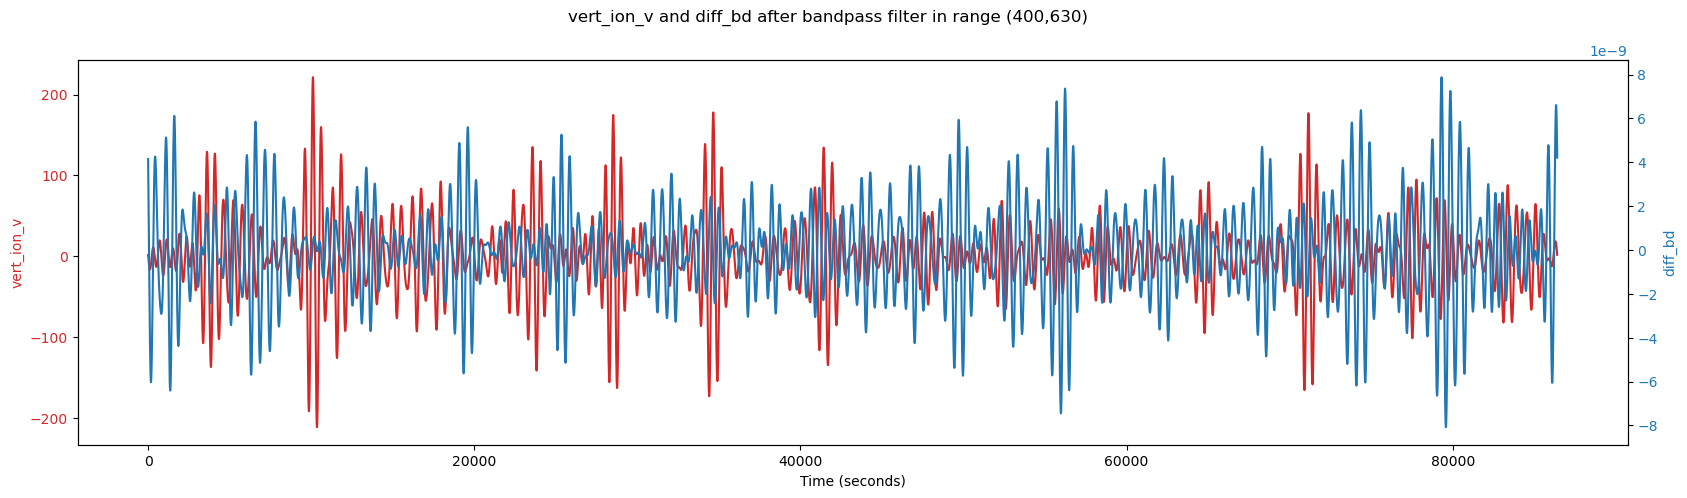

In [4]:
def draw_original_signal(data,v1='vert_ion_v',v2='diff_bd'):
    # original
    data1 = data[v1]
    data2 = data[v2]
    t1 = data1.index.to_numpy()  # va的index和clipped之后的任何来自s1的数据的index一样
    t2 = data2.index.to_numpy()
    if not np.array_equal(t1,t2):
        print("2个数据的index不一样。")
        return 
    t = t1
    signal1 = data1.values
    signal2 = data2.values
    # 绘制原始信号
    fig1 = plt.figure(figsize=(20,5))
    plt.plot(t, signal1)
    plt.title(v1)
    fig2 = plt.figure(figsize=(20,5))
    plt.plot(t, signal2)
    plt.title(v2)
    
    # fre and amplitude
    # fillna
    signal1_fillna = data1.fillna(method='ffill').fillna(method='bfill')
    signal1_fillna = signal1_fillna.values
    signal2_fillna = data2.fillna(method='ffill').fillna(method='bfill')
    signal2_fillna = signal2_fillna.values
    # 进行傅里叶变换
    signal_fft1 = fft(signal1_fillna)
    signal_fft2 = fft(signal2_fillna)
    # 计算对应的频率
    sample_freq1 = fftfreq(signal1_fillna.size, d=t[1] - t[0])
    sample_freq2 = fftfreq(signal2_fillna.size, d=t[1] - t[0])
    # 绘制傅里叶变换结果的幅度谱（双边谱）
    fig3 = plt.figure(figsize=(20,5))
    plt.plot(sample_freq1, np.abs(signal_fft1))
    plt.title(f'Spectrogram after Fourier Transform ({v1})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    fig4 = plt.figure(figsize=(20,5))
    plt.plot(sample_freq2, np.abs(signal_fft2))
    plt.title(f'Spectrogram after Fourier Transform ({v2})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    
    return fig1,fig2,fig3,fig4,sample_freq1,signal_fft1,sample_freq2,signal_fft2,t


def bandpass_filter(v1,v2,sample_freq1,signal_fft1,sample_freq2,signal_fft2,t,epoch1,epoch2):
    # 选取不同频率段，创建一个带通滤波器
    bandpass_filter1 = (sample_freq1 > 1/epoch2) & (sample_freq1 < 1/epoch1)
    filtered_signal_fft1 = signal_fft1.copy()
    filtered_signal_fft1[~bandpass_filter1] = 0
    bandpass_filter2 = (sample_freq2 > 1/epoch2) & (sample_freq2 < 1/epoch1)
    filtered_signal_fft2 = signal_fft2.copy()
    filtered_signal_fft2[~bandpass_filter2] = 0
    # 进行傅里叶反变换，得到过滤后的信号
    filtered_signal1 = np.real(np.fft.ifft(filtered_signal_fft1))
    filtered_signal2 = np.real(np.fft.ifft(filtered_signal_fft2))
    
    fig,ax1 = plt.subplots(figsize=(20,5))
    fig.suptitle(f"{v1} and {v2} after bandpass filter in range ({epoch1},{epoch2})")
    # 绘制第一组数据，使用左侧y轴
    color = 'tab:red'
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel(f'{v1}', color=color)
    ax1.plot(t, filtered_signal1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # 创建第二个坐标轴，共享同一个x轴
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(f'{v2}', color=color)
    ax2.plot(t, filtered_signal2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    return fig   
    
fig1,fig2,fig3,fig4,sample_freq1,signal_fft1,sample_freq2,signal_fft2,t = draw_original_signal(data=data)
fig = bandpass_filter('vert_ion_v','diff_bd',sample_freq1,signal_fft1,sample_freq2,signal_fft2,t,400,630)